In [385]:
import torch
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline

In [386]:
torch.manual_seed(42)
random.seed(42)

In [387]:
# loads Iliad by Homer
text = open('/Users/david/condaProjects/ily.txt', 'r').read()
len(rows)

867076

In [388]:
# hyper parameters 
block_size = 16 # context sizes
n_embd = 12 # size of embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the WaveNet
n_consecutives = 2 # grouping of nodes in the WaveNet
max_steps = 200000 # max steps when training
batch_size = 32 # batch size to be processed during training
learning_rate = 0.01 # learning rate during training

In [389]:
# creating character wise encode and decode functions
chars = sorted(list(set(''.join(rows))))
ctoi = {s: i + 1 for i, s in enumerate(chars)}
ctoi['~'] = 0
itoc = {i:s for s, i in stoi.items()}
vocab_size = len(ctoi)

enc = lambda ch: ctoi[ch]
dec = lambda token: itoc[token]

In [390]:
# creating the training and test datasets
def build_dataset(text, block_size):
    X, Y = [], []
    context = [0] * block_size

    for ch in text + '~':
        ix = enc(ch)
        X.append(context)
        Y.append(ix)

        context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    print(X.shape, Y.shape)
    return X, Y

n = int(0.8 * len(rows))

Xtr, Ytr = build_dataset(rows[:n], block_size)
Xte, Yte = build_dataset(rows[n:], block_size)

torch.Size([693661, 16]) torch.Size([693661])
torch.Size([173417, 16]) torch.Size([173417])


In [391]:
for x, y in zip(Xtr[:10], Ytr[:10]):
    print(''.join(dec(ix.item()) for ix in x), '-->', dec(y.item()))

~~~~~~~~~~~~~~~~ --> A
~~~~~~~~~~~~~~~A --> c
~~~~~~~~~~~~~~Ac --> h
~~~~~~~~~~~~~Ach --> i
~~~~~~~~~~~~Achi --> l
~~~~~~~~~~~Achil --> l
~~~~~~~~~~Achill --> e
~~~~~~~~~Achille --> s
~~~~~~~~Achilles --> ’
~~~~~~~Achilles’ -->  


In [392]:
# custom module for the WaveNet
class FlattenCons(nn.Module):
    def __init__(self, n):
        self.n = n
    
    def __call__(self, x):
        B, T, C = x.shape
        x = torch.reshape(x, (B, T//self.n, C*self.n))
        
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        
        return self.out        

class Permute(nn.Module):
    def __call__(self, x):
        out = x.permute(0, 2, 1)
        
        return out  

In [393]:
# initializing the layers
modules =  [
    nn.Embedding(vocab_size, n_embd),
    FlattenCons(n_consecutives), nn.Linear(n_embd * n_consecutives, n_hidden, bias=False), Permute(), nn.BatchNorm1d(n_hidden), Permute(), nn.Tanh(),
    FlattenCons(n_consecutives), nn.Linear(n_hidden * n_consecutives, n_hidden, bias=False), Permute(), nn.BatchNorm1d(n_hidden), Permute(), nn.Tanh(),
    FlattenCons(n_consecutives), nn.Linear(n_hidden * n_consecutives, n_hidden, bias=False), Permute(), nn.BatchNorm1d(n_hidden), Permute(), nn.Tanh(),
    FlattenCons(n_consecutives), nn.Linear(n_hidden * n_consecutives, n_hidden, bias=False), nn.BatchNorm1d(n_hidden), nn.Tanh(),
    nn.Linear(n_hidden, vocab_size)
    ]

# initializing the model
model = nn.Sequential(*modules)

with torch.no_grad():
    model[-1].weight *= 0.1 # make last later less confident
    
parameters = [p for p in model]

for p in parameters:
    if not isinstance(p, Permute) and not isinstance(p, FlattenCons) and not isinstance(p, nn.Tanh):
        p.weight.requires_grad = True

In [394]:
losses = []

# trains using gradient descent optimizer
for i in range(max_steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    feed_x = Xb
    logits = model(feed_x)

    loss = F.cross_entropy(logits, Yb) # loss function
    # backward pass
    for p in parameters:
        if not isinstance(p, Permute) and not isinstance(p, FlattenCons) and not isinstance(p, nn.Tanh):
            p.weight.grad = None
    loss.backward()
    
    losses.append(loss)

    lr = learning_rate if i < max_steps * 0.75 else learning_rate / 10
    for p in parameters:
        if not isinstance(p, Permute) and not isinstance(p, FlattenCons) and not isinstance(p, nn.Tanh):
            p.weight.data += -lr * p.weight.grad
        
    losses.append(loss.log10().item())
    
    if i % 20000 == 0:
        print(loss.item())

4.412376880645752
2.147263288497925
1.634331226348877
1.3853158950805664
1.6208477020263672
1.3605211973190308
1.6196937561035156
1.363328456878662
1.1307172775268555
1.3015536069869995


In [395]:
# set training to false
for p in parameters:
    p.training = False

In [396]:
losses = torch.tensor(losses).view(-1, 1000).mean(1) 

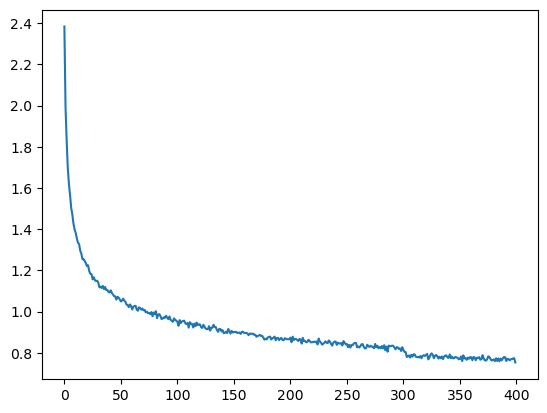

In [397]:
# plots the losses during training
plt.plot(losses)

In [398]:
# evaluate on both train and test (see potential overfitting)
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'test': (Xte, Yte)
    } [split]
    
    logits = model(x) 
    
    loss = F.cross_entropy(logits, y) 
    print(split, loss.item())

split_loss('train')
split_loss('test')

train 1.3537029027938843
test 1.4958065748214722


In [399]:
# generate an output starting from context of block_size consecutive special characters ~
out = []
context = [0] * block_size

while True:
    feed_x = torch.tensor([context])

    logits = model(feed_x)
    probs = F.softmax(logits, dim = 1)

    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(dec(ix))

    if ix == 0:
        break

print(''.join(s for s in out if s != '~'))

rous the shades, and Po dame or kenguard his nervest battling prelwout in the prome, and to the days a long, Collect fair and victor pospitap’d to strong; all the storus, and braves tour golden woed, and men,
At thee through heaps known unred, and heaven/.
A tate, bulöven it so whom forby the tower;
By Jove the monarches middep’s yet and sulertoristingïp; from imploopoke.
Enzove this will,
Nor a—twing helmet his laid;
To tarter, secret brothere bold her field; the circle spraise: and savon’s prince.
Such ye his sage
Of had dext Prives.

”eaon inters’ wing, in the from who sworce and Tortal conding god thee, in a her bleeds,
Each mydaning victor, saved, his risife, fon in the gods of sangues reign,
Jove seik, succenombedy stoopp’d the plain.
As Jove forman glory;
Great streful her Gell the borning heart.
Geeds and own; king soul exterved by the, for every, assal sheads!
Now to the the Greciors led his waithin, for the dever-hisol’d till no more;
To rite, and fired,
And fruets and great 